## Scope of Exercise 3

The goal of this project is to collect data about cities and countries, clean and merge the data to finally answer the following questions:

* How do the rankings change over time?
* How do these rankings correlate with each other for one specific year?
* How do they correlate with other statistics about the countries in which
  the cities are located?
* How do they correlate with quality of life rankings of the country
  in which the cities are located?
* What are the determining characteristics for livability of a city?
  How do they correlate with cost of living?

## How do the rankings change over time?
As a first step we look at the Numbeo Dataset and analyze the different indices visually over time

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
dfNumbeo = pd.read_csv(r"data\Numbeo.csv",sep=";",decimal=",")
dfNumbeo.columns = ['Period', 'City', 'QualityOfLife', 'PurchasingPower', 'Safety', 'HealthCare', 'CostOfLiving', 'PropertyPriceToIncomeRatio', 'TrafficCommuteTime','Pollution', 'Climate']
dfNumbeo

,Period,City,QualityOfLife,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate
0,2020,"Caracas, Venezuela",0.00,2.36,15.10,39.28,27.68,150.55,34.69,72.41,99.93
1,2020,"Auckland, New Zealand",165.38,83.93,54.54,73.43,76.06,12.09,37.96,29.19,99.89
2,2020,"Guatemala City, Guatemala",107.71,40.18,37.39,63.63,44.26,9.89,50.11,69.66,99.89
3,2020,"Nairobi, Kenya",73.29,24.85,39.92,56.46,42.08,26.17,56.94,80.42,99.79
4,2020,"Medellin, Colombia",117.13,29.90,48.66,77.28,30.19,17.90,38.29,64.89,99.76
...,...,...,...,...,...,...,...,...,...,...,...
2304,2012-Q1,"Cairo, Egypt",-35.66,18.35,61.33,70.83,52.69,15.51,58.75,129.50,NaN
2305,2012-Q1,"Tehran, Iran",-50.44,47.52,43.27,43.40,60.86,13.72,73.50,140.75,NaN
2306,2012-Q1,"Moscow, Russia",-54.72,46.75,47.33,37.75,86.77,28.06,61.50,116.61,NaN
2307,2012-Q1,"Kolkata, India",-74.08,49.55,27.97,19.72,32.96,15.13,74.25,145.50,NaN


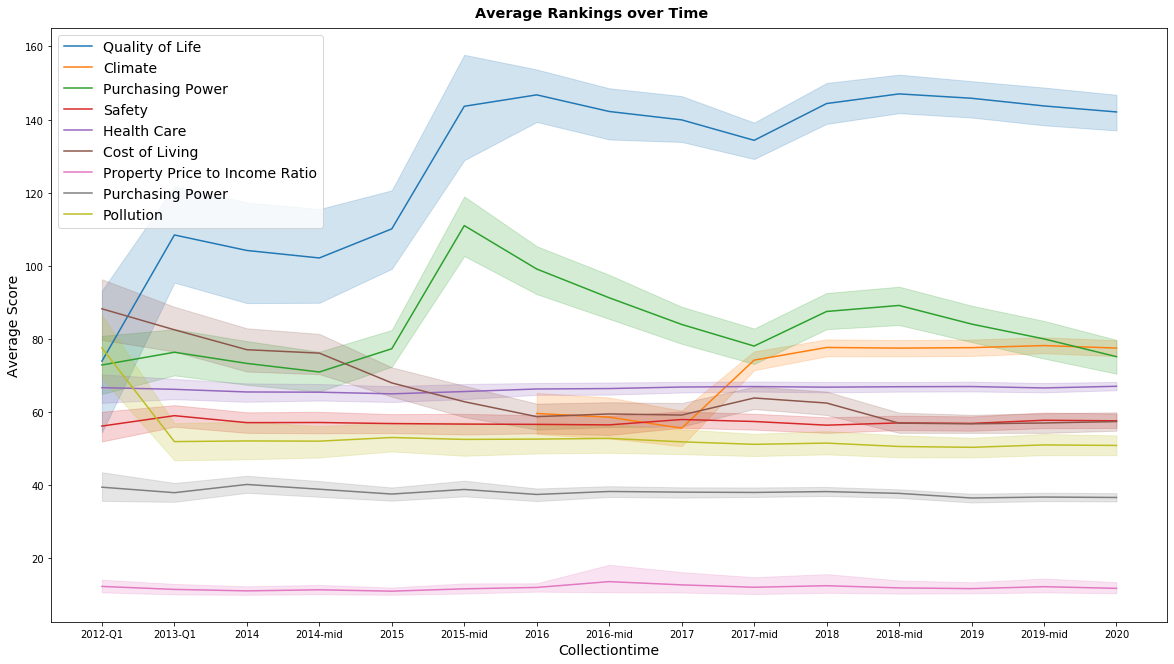

In [42]:
#How do the rankings change over time?

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
fig.suptitle('Average Rankings over Time', fontsize='x-large', fontweight='bold')
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.
fig.subplots_adjust(top=0.95)


ax = fig.add_subplot(111)

fontdict={'fontsize': 14, 'fontweight' : 'book',    'verticalalignment': 'baseline',   'horizontalalignment': 'center'}

#ax.set_title('Plotting Tutorial', fontdict=fontdict)

sns.lineplot(x="Period", y="QualityOfLife", data=dfNumbeo,legend='brief',label='Quality of Life')
sns.lineplot(x="Period", y="Climate", data=dfNumbeo,legend='brief',label='Climate')
sns.lineplot(x="Period", y="PurchasingPower", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Safety", data=dfNumbeo,legend='brief',label='Safety')
sns.lineplot(x="Period", y="HealthCare", data=dfNumbeo,legend='brief',label='Health Care')
sns.lineplot(x="Period", y="CostOfLiving", data=dfNumbeo,legend='brief',label='Cost of Living')
sns.lineplot(x="Period", y="PropertyPriceToIncomeRatio", data=dfNumbeo,legend='brief',label='Property Price to Income Ratio')
sns.lineplot(x="Period", y="TrafficCommuteTime", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Pollution", data=dfNumbeo,legend='brief',label='Pollution')

plt.legend(fontsize=14)
#plt.title('Average Rankings over Time', fontdict=fontdict, color="black", position=(0.5,1));
plt.xlabel('Collectiontime', fontsize=14)
plt.ylabel('Average Score', fontsize=14);
fig.savefig('visuals/RankingsOverTime.png')

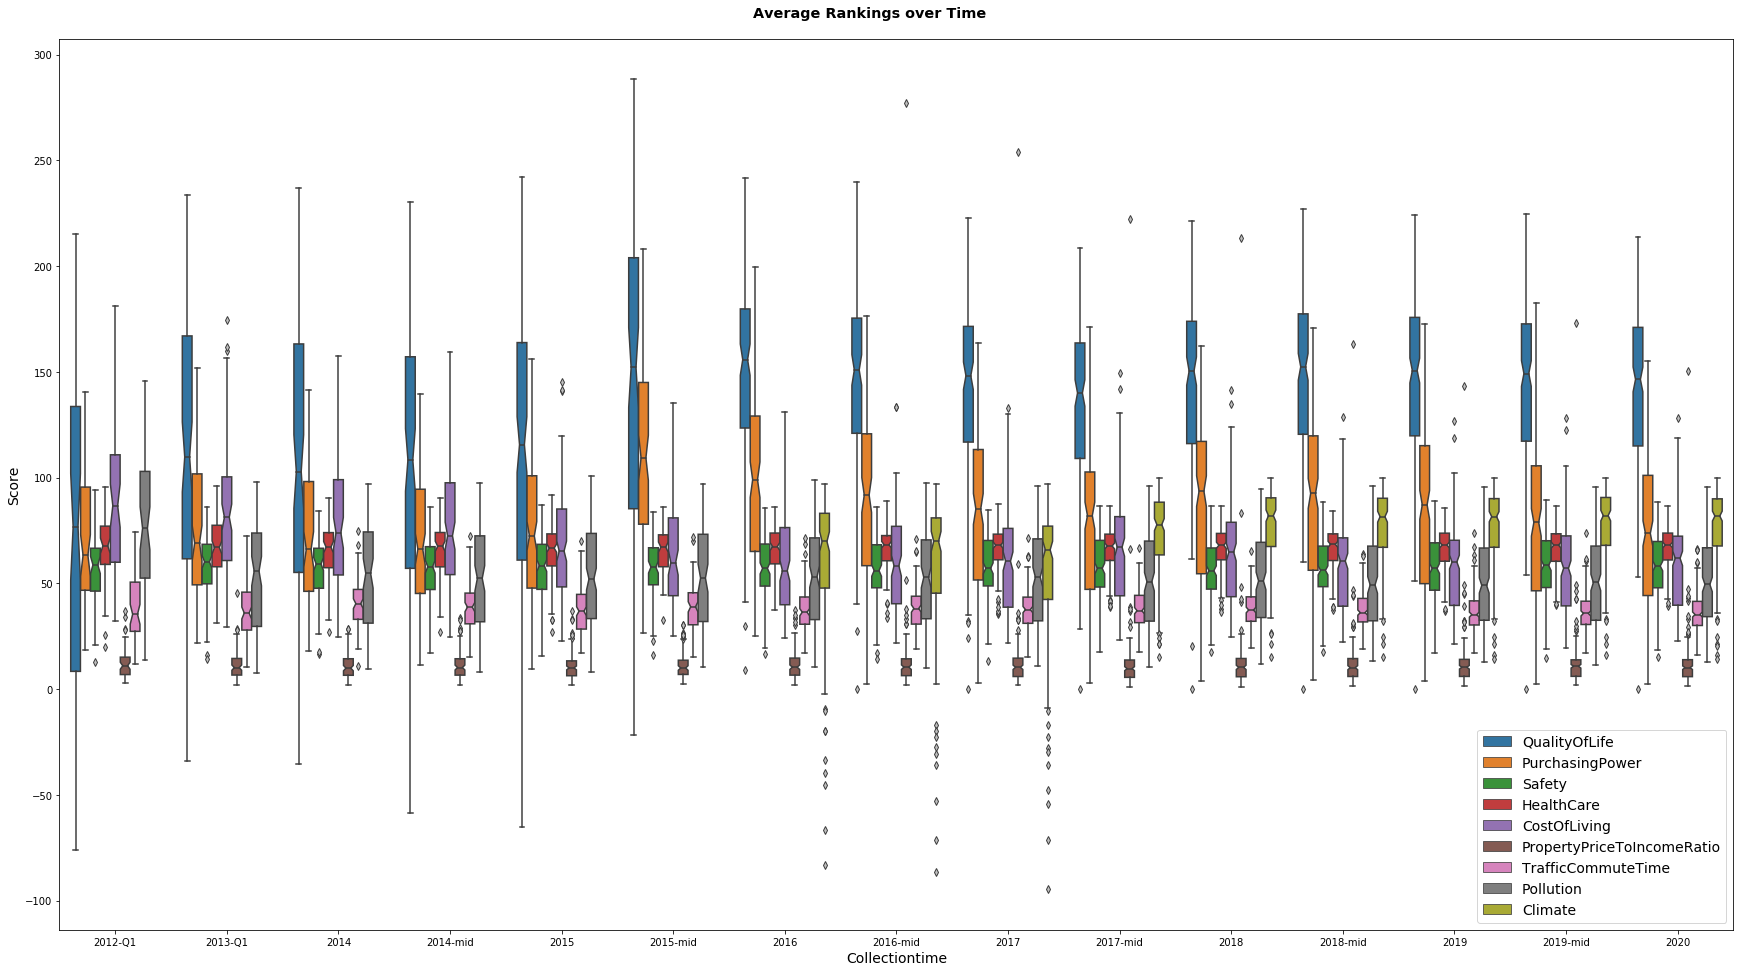

In [4]:
#There might be some outliers in the data so we decided to also look at a boxplot:
fig = plt.figure(figsize=(30,15))
fig.suptitle('Average Rankings over Time', fontsize='x-large', fontweight='bold')
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.
fig.subplots_adjust(top=0.95)


ax = fig.add_subplot(111)

fontdict={'fontsize': 14, 'fontweight' : 'book',    'verticalalignment': 'baseline',   'horizontalalignment': 'center'}

#ax.set_title('Plotting Tutorial', fontdict=fontdict)

dfNumbeoPivoted = pd.melt(dfNumbeo, col_level=0, id_vars=['Period', 'City'], value_vars=['QualityOfLife', 'PurchasingPower', 'Safety', 'HealthCare', 'CostOfLiving', 'PropertyPriceToIncomeRatio', 'TrafficCommuteTime','Pollution', 'Climate'])


flierprops = dict(markerfacecolor='0.75', markersize=5,    linestyle='none')
g = sns.boxplot(x="Period", y="value",hue="variable",notch=True, data=dfNumbeoPivoted,order=np.flip(dfNumbeo.Period.unique()),flierprops=flierprops)

plt.legend(fontsize=14)
#plt.title('Average Rankings over Time', fontdict=fontdict, color="black", position=(0.5,1));
plt.xlabel('Collectiontime', fontsize=14)
plt.ylabel('Score', fontsize=14);
fig.savefig('visuals/RankingsOverTimeBoxPlot.png')

## Interpretation
The Quality of life rankings on average increased from 2012 to 2015. Then they decreased a bit till mid 2017 and recovered again to mid 2018. 
After that the quality of life ranking decreased again. TODO: Identify the outliers and explain them.


## How do city ratings correlate with quality of life rankings of the country in which the cities are located?


TODO: For this we should integrate the data about cities

## How do these rankings correlate with each other for one specific year?
TODO: For that we should import the mercer data and integrate them with the data from Numbeo...

## How do they correlate with other statistics about the countries in which the cities are located? 
TODO: For this we should integrate the data about cities

## What are the determining characteristics for livability of a city? How do they correlate with cost of living?

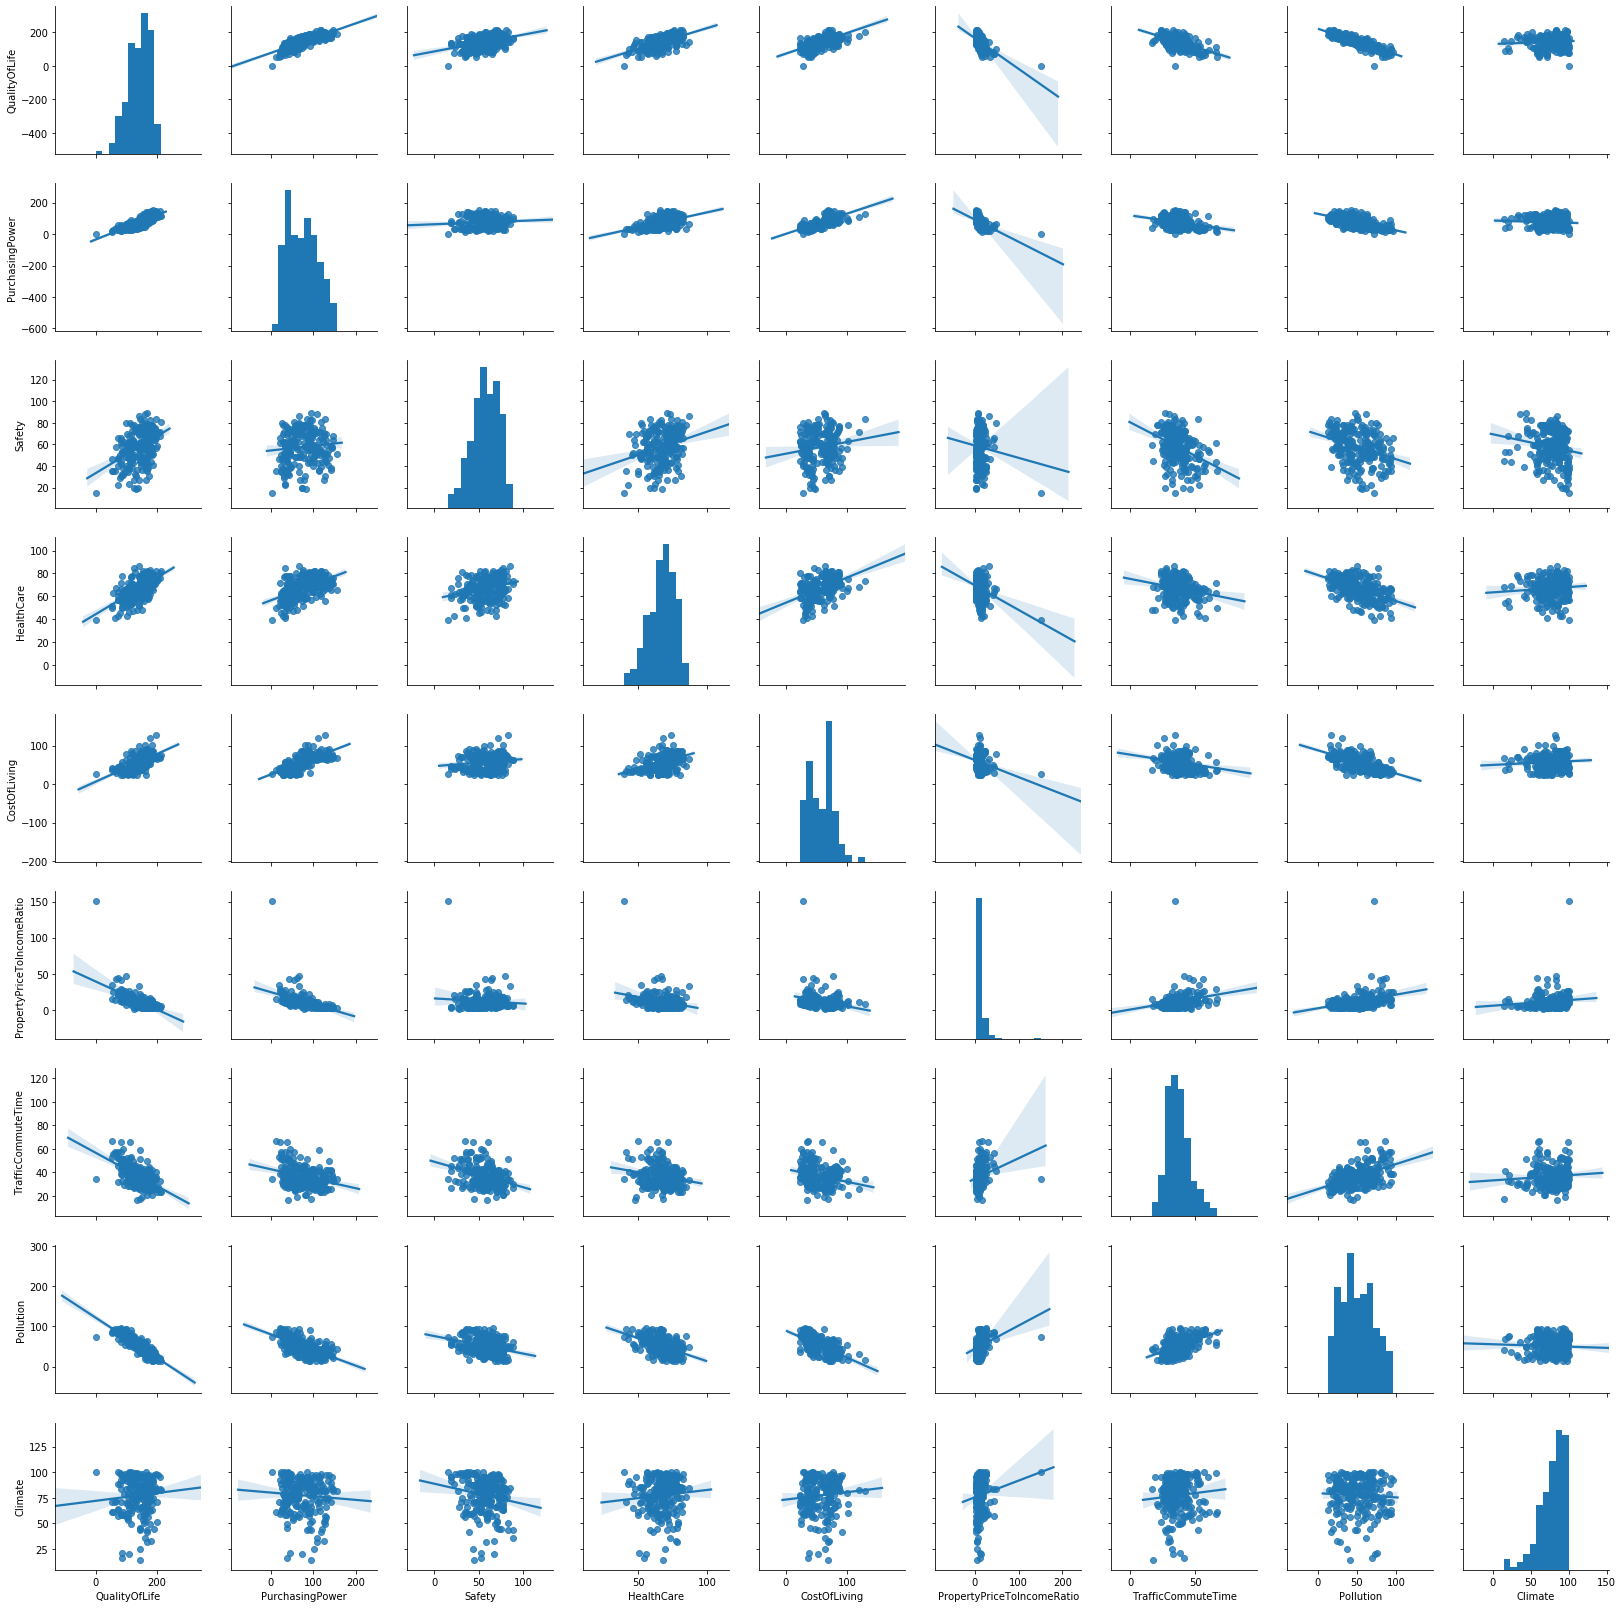

In [79]:
#for this question we will look at the most recent Numbeo data (2020) and make a visual analysis. 
#after that we will train a linear regression model in r and interpret the inference statistics

dfNumbeo2020 = dfNumbeo.set_index('Period').loc['2020',:]
#dfNumbeo2020
sns.pairplot(dfNumbeo2020,kind="reg")


In [62]:
#find the outliers
#taken from https://stackoverflow.com/questions/46827580/multivariate-outlier-removal-with-mahalanobis-distance
def MahalanobisDist(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


def MD_detectOutliers(data, extreme=False, verbose=False):
    MD = MahalanobisDist(data, verbose)
    # one popular way to specify the threshold
    #m = np.mean(MD)
    #t = 3. * m if extreme else 2. * m
    #outliers = []
    #for i in range(len(MD)):
    #    if MD[i] > t:
    #        outliers.append(i)  # index of the outlier
    #return np.array(outliers)

    # or according to the 68–95–99.7 rule
    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)


def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False


def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    df = noisy_data 
    #using a multivariate outlier detection based on mahalanobis distance from 
    #https://stackoverflow.com/questions/46827580/multivariate-outlier-removal-with-mahalanobis-distance
    outliers_indices = MD_detectOutliers(df.iloc[:,2:10].values, verbose=False)

    print("Outliers Indices: {}\n".format(outliers_indices))
    df = df.reset_index()
    inliers = pd.Int64Index(np.arange(len(df))).difference(outliers_indices)
    cleaned_data = df.iloc[inliers]
    return cleaned_data
    
dfNumbeo2020_cleaned = handle_outliers(dfNumbeo2020).set_index('Period')


Outliers Indices: [  0 226]



In [60]:
#looking at the outliers:
dfNumbeo2020.iloc[[0,226],:]

,City,QualityOfLife,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate
Period,,,,,,,,,,
2020,"Caracas, Venezuela",0.00,2.36,15.10,39.28,27.68,150.55,34.69,72.41,99.93
2020,"Regina, Canada",144.46,95.08,44.51,68.15,68.19,4.97,17.17,41.21,14.28


<Figure size 2160x1080 with 0 Axes>

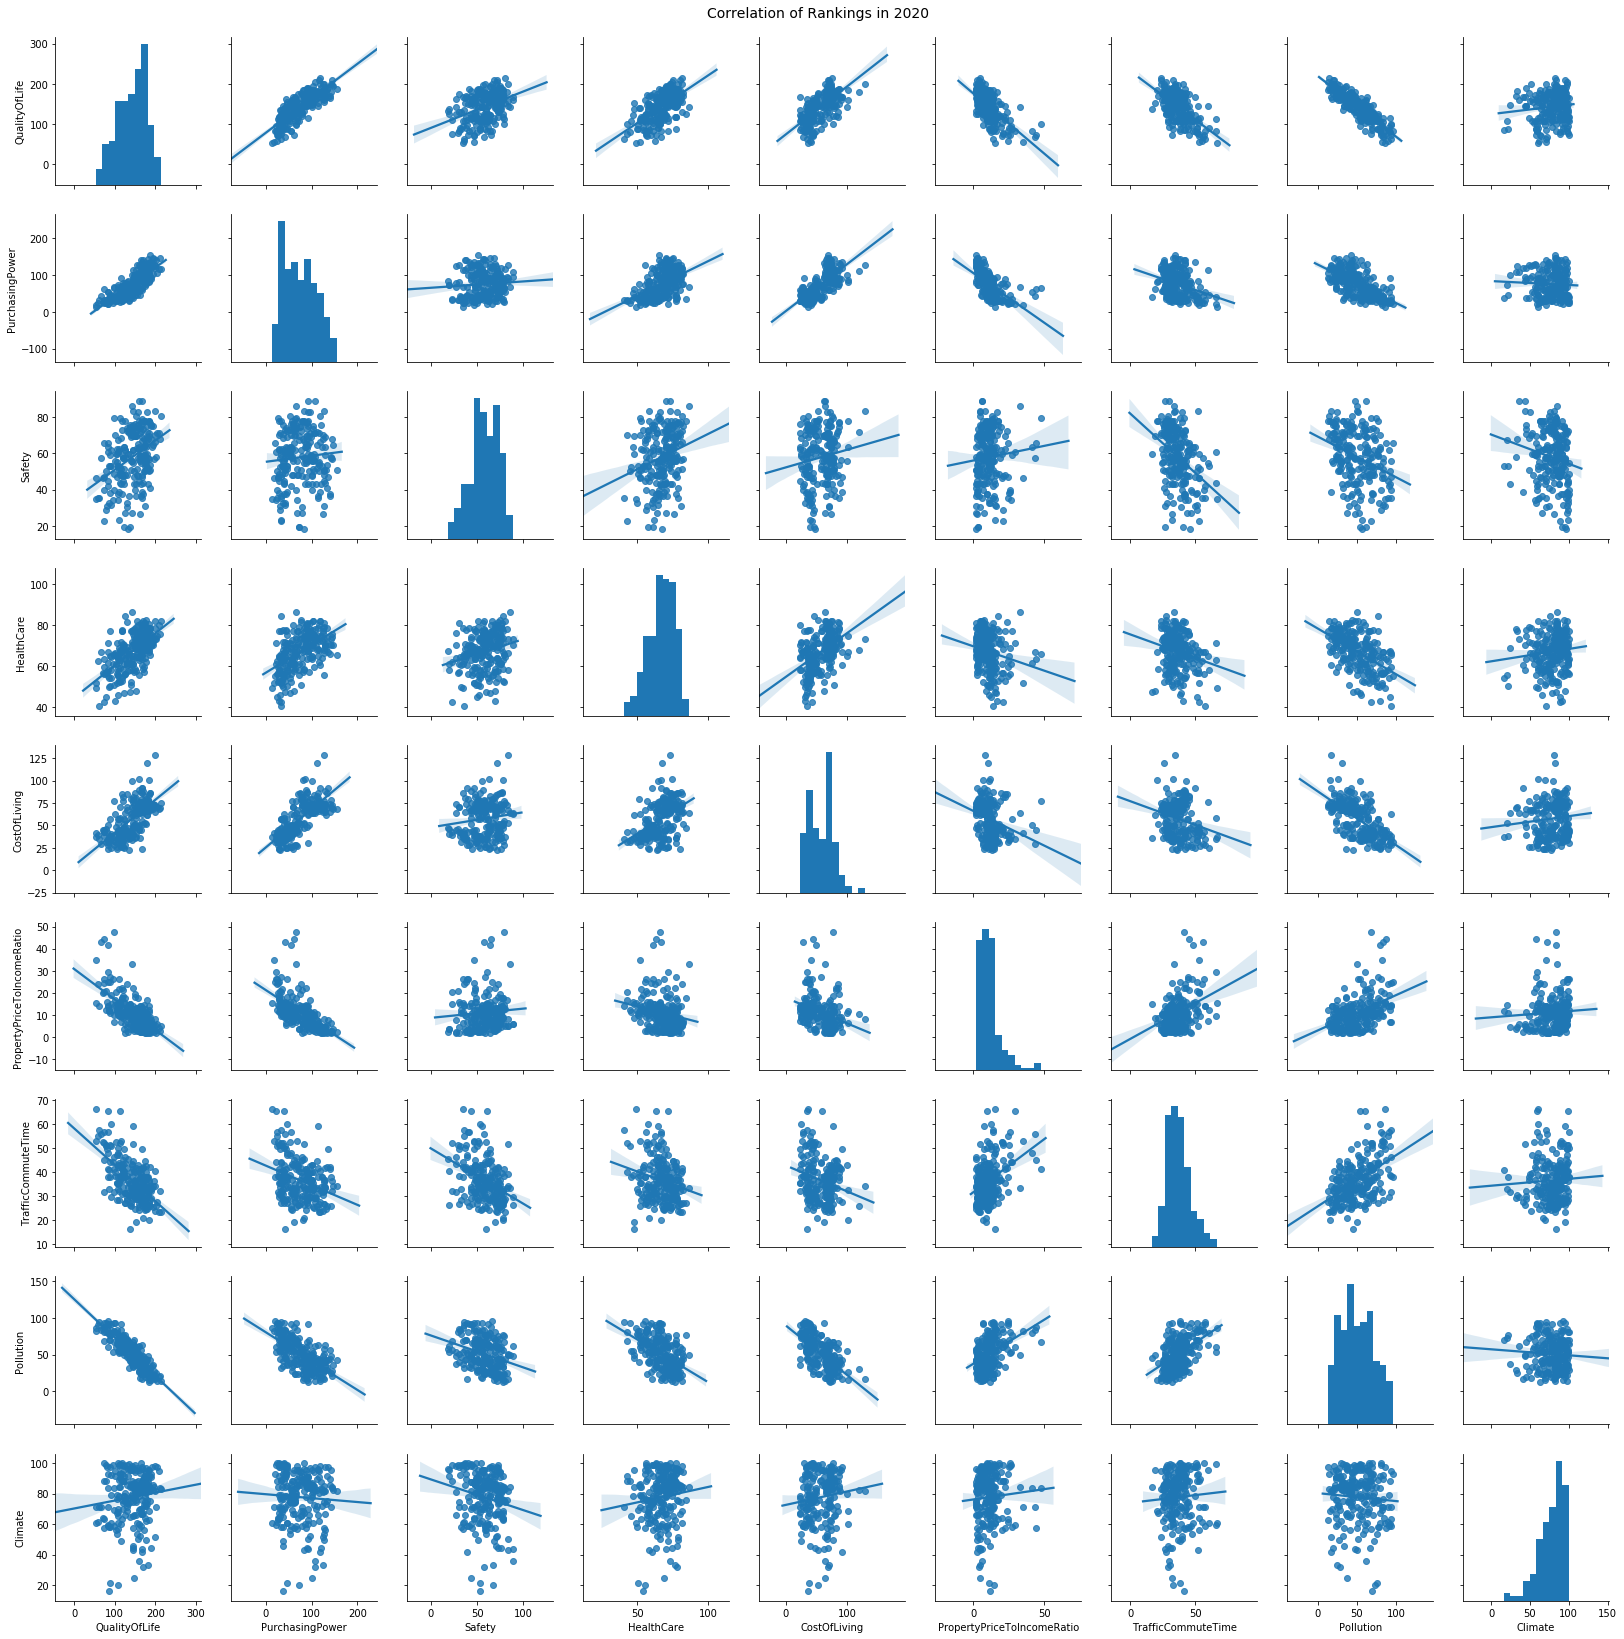

In [77]:
#plotting again without outliers
#dfNumbeo2020_cleaned

fig = plt.figure(figsize=(30,15))
#fig.suptitle('Correlation of Rankings in 2020', fontsize='x-large', fontweight='bold')
fig.subplots_adjust(top=0.95)

#ax = fig.add_subplot(111)
g = sns.pairplot(dfNumbeo2020_cleaned,kind="reg")

g.fig.suptitle("Correlation of Rankings in 2020", y=1.01,fontsize=14)

# plt.title('Correlation of Rankings in 2020', fontdict=fontdict, color="black", position=(0.5,1));

fig.savefig('visuals/CorrelationOfRankingsIn2020.png')

In [78]:
g.fig.savefig('visuals/CorrelationOfRankingsIn2020.png')

In [96]:
#g = sns.boxplot(x="Period", y="value",hue="variable", data=dfNumbeoPivoted,order=np.flip(dfNumbeo.Period.unique()))
#dir(g)

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R -o output
d <- read.csv2("data/Numbeo.csv",sep=';',dec =',')
n <- nrow(d)
set.seed(123)
train <- sample(1:n,round(n*2/3))

res <- lm(Cost.of.Living.Index~Purchasing.Power.Index+Safety.Index+Health.Care.Index+Quality.of.Life.Index+Property.Price.to.Income.Ratio+Traffic.Commute.Time.Index+Pollution.Index+Climate.Index,data=d[train,])
summary(res)
output <- capture.output({summary(res) })


In [3]:
print(output)

 [1] ""                                                                        

 [2] "Call:"                                                                   

 [3] "lm(formula = Cost.of.Living.Index ~ Purchasing.Power.Index + "           

 [4] "    Safety.Index + Health.Care.Index + Quality.of.Life.Index + "         

 [5] "    Property.Price.to.Income.Ratio + Traffic.Commute.Time.Index + "      

 [6] "    Pollution.Index + Climate.Index, data = d[train, ])"                 

 [7] ""                                                                        

 [8] "Residuals:"                                                              

 [9] "    Min      1Q  Median      3Q     Max "                                

[10] "-49.177  -7.587  -1.225   7.092  70.271 "                                

[11] ""                                                                        

[12] "Coefficients:"                                                           

[13] "                      

## Interpretation

From the visual analysis we see that there is a strong postive correlation of the cost of living and the quality of life, purchasing power, safety.
The higher the cost of living the lower is the ratio between the property prices and the income. Also the cost of living is lower when the commute time index or the pollution is high.
In addition the climate index seems to also increase the cost of living. This is also confirmed by the inference statistics of the simple regression model. 

The model shows coefficients significant from 0 for all indices. 